# Data Workshop 2

**Instructor:** Jared Brzenski jabrzenski@ucsd.edu

**TAs:** Tommy Stone           tstone@ucsd.edu


This can be run as MATLAB or Python, depending on the environment chosen.

MATLAB will be run first. If you want to skip to Python, scroll down to the **Python** header!

For MATLAB, run ```pip install jupyter-matlab-proxy``` in your environmnet and activate MATLAB in the upper right corner.


# MATLAB 

# Raw Data
Lets say we are given the task of analyzing the hsitorical data fro mthe water gauge station at the [Prado Dam in Los Angeles](https://waterdata.usgs.gov/monitoring-location/USGS-11074000/#dataTypeId=continuous-00065-0&period=P7D).

We want to download the [data](data/PradoDam.txt), clean it, and do some spectral analysis on it to see if there is anything interesting.



## Reading in the data

If we do a quick check of the file, we note there is a giant header, then some columns of data.
```
# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2020-04-29 18:30:02 EDT       (caww01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 11074000 SANTA ANA R BL PRADO DAM CA
# -----------------------------------------------------------------------------------
#
# Data provided for site 11074000
#            TS   parameter     statistic     Description
#          8183       00060     00003     Discharge, cubic feet per second (Mean)
#
# Data-value qualification codes included in this output:
#     A  Approved for publication -- Processing and review completed.
#     P  Provisional data subject to revision.
#     e  Value has been estimated.
# 
agency_cd	site_no	datetime	8183_00060_00003	8183_00060_00003_cd
5s	15s	20d	14n	10s
USGS	11074000	1940-09-30	51.0	A
USGS	11074000	1940-10-01	47.0	A
USGS	11074000	1940-10-02	47.0	A
USGS	11074000	1940-10-03	47.0	A
```


This tells us the pertinent information about the file, where it came from, and what format the data displayed is in.

In MATLAB, we can load this data in by giving the filename of the data location, and using readtable.

In [103]:
% MATLAB
% read in a text file

filename = 'data/PradoDam.txt';

% Offer a helpful hint if we cant find the file
[path, name, ext] = fileparts(filename);
if ext ~= '.txt'
    fprint("Wrong file extension given.\n");
    return;
end

% We could read in the data raw with
% ff = importdata(filename);

% Or, read it in as a table with
f =  readtable(filename);

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.

WE can examine the data by viewing the ```f``` variable, and note it is in columns already. we are interested in column 3 and 4, the date and measurements.

In [104]:
% MATLAB
date = f{:,3};
flow = f{:,4};
% Convert the date from a string into datenum object so MATLAB can do date specific work.
date = datenum( f{:,3} );

In [105]:
%MATLAB
% Lets say we need a monthly average, we can do that with indexing ?!?
months = month(date)

for ii=  1:12
    indexes = find(months == ii);
    Total(ii) = sum( flow(indexes) );
    Average(ii) = Total(ii) / length(indexes);
end

date = datetime( date , 'ConvertFrom', 'datenum' );

save ('save_data.mat', 'date', 'flow' );



months = 29066x1 double
     9
    10
    10
    10
    10
    10
    10
    10
    10
    10
...

And conversely, if we are missing a newer MATLAB, or want to do this the way MATLAB is doing it under the hood, this is the equivalent to the above code. Be carefuly running it, it will clobber the variables in the above cells!

## Removing NaNs
If you scrolled through the data, you noticed there were some missing values, dates, etc. WE need to remove those from our data set. How can we find them efficiently?

In [106]:
% MATLAB 
% clean NaNs
inan = find(isnan(flow));
flow(inan) = [];           % This effectively removes the entry
date(inan) = [];           % Do not forget the dates as well

% Other equivalent ways of finding nans in dates
% isnat == is not a time
% if date is a date string

% If we did everything correct, then this should be equal to zero
inad = find(isnat(date))


inad =

  0x1 empty double column vector



## Interpolation
We look at the data, there may be time gaps, holes, etc. But we want a nice, steady time series.

**We INTERPOLATE!**

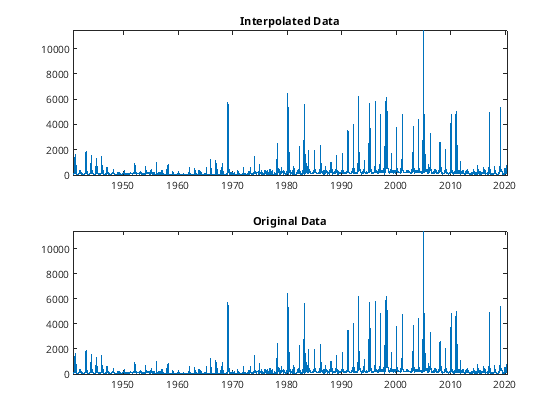

In [107]:
% Interpolate for hourly times
% using interp1

firstday = datenum( date(1) );    % first time
lastday  = datenum( date(end) );  % last time
xq = firstday : 1/24 : lastday;   % make a vector with perfect hour spacing
yq = interp1(datenum(date), flow, xq, 'pchip'); % Interpolate to that perfectly spaced vector
close all
subplot(2,1,1)
xq_datetime = datetime( xq , 'ConvertFrom', 'datenum' );
plot(xq_datetime,yq); title('Interpolated Data');
subplot(2,1,2)
plot(date, flow); title('Original Data');



## Filtering Data

OK, now lets filter this data, to see some sort of pattern in the data.

This is usually the first part of spectral analysis, where we look and see if there are any time (frequency) components to our data.

Generic Example:

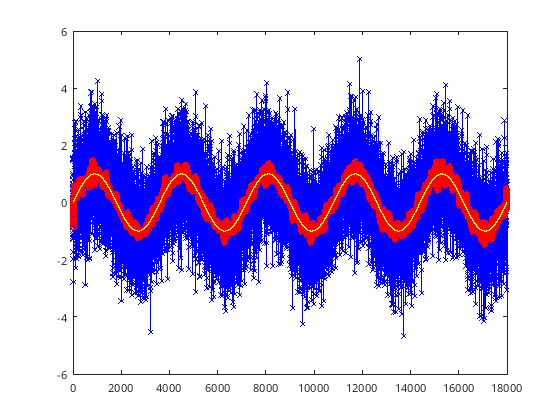

In [108]:
%% Filters
% deciding what filter to use on your data. This is personal, decide what
% is the best option. This uses the Butterworth filter "butter"

t = 0 : 1 : 5*3600;                       % Time, maybe when measurements were taken
y = sin(t*2*pi/3600) + randn(size(t));    % Nice cyclic data, with noise added

% Setup some values for our filters
T = t(2) - t(1);   % 1 second
samplingf = 1/T;   % 1 Hz
cutoff = 1/(60);   % 1/60 Hz, 1/1 min cutoof frequencies higher than this

% First have to setup filter, with parameters A,B
[B A] = butter(2, cutoff/(0.5*samplingf), 'low');
% Filter the y data, save is as fy
fy = filtfilt(B, A, y);

%% Plot the results
% Original noisy data
figure
plot(t,y, 'b-x');
hold on;
% Filtered data, (red line)
plot(t,fy,'r-o');
hold on;
% Original, non-noisy function (yellow line)
plot(t, sin(t*2*pi/3600), 'y');


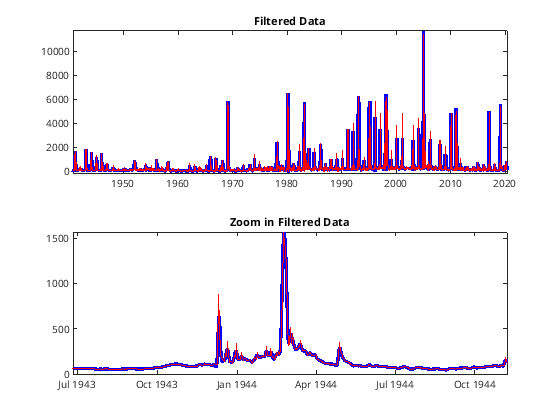

In [109]:
%%
figure
cutoff = 1/7;  % (less than weekly )
T = 1/( datenum(date(2)) - datenum( date(1) ) );
[B A] = butter(2, cutoff/(0.3*T), 'low');

% Aplly the filt forwards and backwards, to try to prevent phase shifting
fx = filtfilt(B,A,flow);


tiledlayout(2,1)
nexttile
plot(date,fx, 'b-', 'LineWidth',3); hold on;
plot(date, flow, 'r');
title('Filtered Data');

nexttile
plot(date,fx, 'b-', 'LineWidth',3); hold on;
plot(date, flow, 'r');
title('Zoom in Filtered Data')
xlim([date(1000) date(1500)]);

## Spectral Analysis - Fourier Space

Now, we can take out filtered data, and analyze it in Fourier (frequency) space

dim = 1

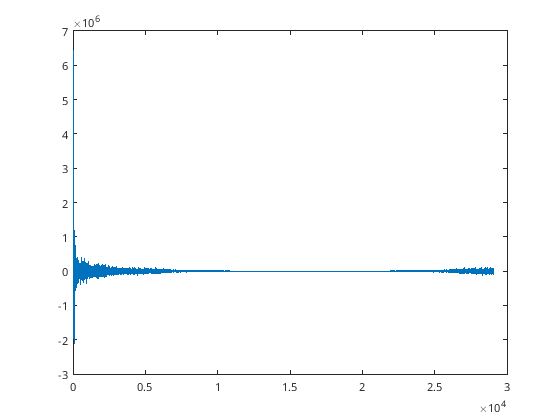

In [110]:
% Make date back into a number
d = datenum(date);
d = d - d(1) + 1;

L=length(date);
n=2^nextpow2(L);
dim=1

% Take the Fast-Fourier-Transform to put in phase space
orig=fft(fx,n,dim);

figure
plot(d, orig(1:length(d)));

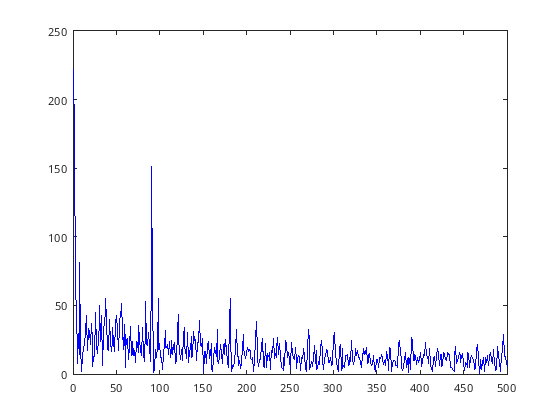

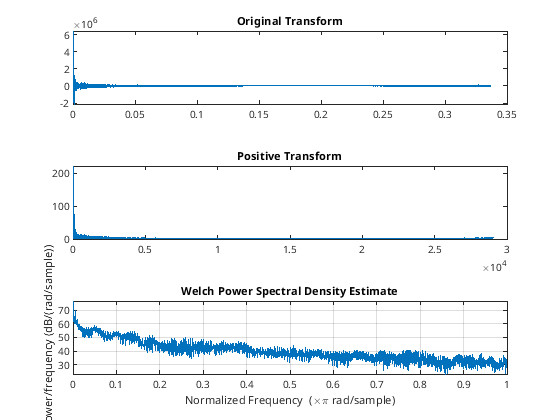

In [111]:
P2 = abs(orig / L);

P1 = P2(1:n/2 + 1);
P1(2:end-1) = 2*P1(2:end-1);
d = datenum(date);
d = d - d(1) + 1;
figure
plot(d(1:500), P1(1:500), 'b-');


figure
tiledlayout(3,1)
nexttile
% Original Transformed Data
plot(d/86400, orig(1:length(d))); title('Original Transform');
nexttile
% All Positive
plot(d,P2(1:length(d))); title('Positive Transform');
nexttile
% MATLAB has built-in functions or other stuff
pwelch(flow)

In [112]:
% MATLAB - Not necessary to run, also SUPER SLOW!!!!!!
%raw_data = importdata(filename);
%[nr nc] = size(raw_data);
%date = zeros(nr,1);
%Flow = zeros(nr,1);

% Scan the rows for a string, string, string, float, and a string

%for ii = 1:nr
  %  row = textscan( raw_data{ii}, '%s%s%s%f%s');
  %  agency = row{1};
 %   % Check if the first string says USGS, we know we in the data!
%    if strcmp(agency, 'USGS')
%        date(ii) = datenum(row{3});
%        flow(ii) = row{4};
%    end
%end

%[nr nc] = size(f);
%date = zeros( nr, 1);
%Q = zeros( nr, 1);

% Import the date and time and plot

%date =  f{:,3} ;
%flow =  f{:,4};

%figure
%plot(date, flow)
%xtickformat('dd-MMM-yyyy');

# Python

# Raw Data
Lets say we are given the task of analyzing the hsitorical data fro mthe water gauge station at the [Prado Dam in Los Angeles](https://waterdata.usgs.gov/monitoring-location/USGS-11074000/#dataTypeId=continuous-00065-0&period=P7D).

We want to download the [data](data/PradoDam.txt), clean it, and do some spectral analysis on it to see if there is anything interesting.



## Reading in the data

If we do a quick check of the file, we note there is a giant header, then some columns of data.
```
# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2020-04-29 18:30:02 EDT       (caww01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 11074000 SANTA ANA R BL PRADO DAM CA
# -----------------------------------------------------------------------------------
#
# Data provided for site 11074000
#            TS   parameter     statistic     Description
#          8183       00060     00003     Discharge, cubic feet per second (Mean)
#
# Data-value qualification codes included in this output:
#     A  Approved for publication -- Processing and review completed.
#     P  Provisional data subject to revision.
#     e  Value has been estimated.
# 
agency_cd	site_no	datetime	8183_00060_00003	8183_00060_00003_cd
5s	15s	20d	14n	10s
USGS	11074000	1940-09-30	51.0	A
USGS	11074000	1940-10-01	47.0	A
USGS	11074000	1940-10-02	47.0	A
USGS	11074000	1940-10-03	47.0	A
```


In [3]:
# Python
import os
import pandas as pd
import numpy as np
import scipy.io
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt

In [20]:
# === Load the data (equivalent to readtable) ===
filename = "data/PradoDam.txt"
path, full_filename = os.path.split(filename)
name, ext = os.path.splitext(full_filename)

if ext.lower() != ".txt":
    print("Wrong file extension given.")
    raise SystemExit

# Read file, skipping lines starting with '#'
raw = pd.read_csv(
    filename,
    comment="#",           # ignore all lines starting with '#'
    sep="\t",              # tab-delimited
    header=None,              # first non-comment line is header
    dtype=str              # read as strings first (safe)
)

# First row becomes header, drop second row (format specifiers)
raw.columns = raw.iloc[0]       # set column names from first row
f = raw.drop(index=0).drop(index=1)  # remove first and second row
f = f.reset_index(drop=True)    # reindex after dropping
f

,agency_cd,site_no,datetime,8183_00060_00003,8183_00060_00003_cd
0,USGS,11074000,1940-09-30,51.0,A
1,USGS,11074000,1940-10-01,47.0,A
2,USGS,11074000,1940-10-02,47.0,A
3,USGS,11074000,1940-10-03,47.0,A
4,USGS,11074000,1940-10-04,55.0,A
...,...,...,...,...,...
29061,USGS,11074000,2020-04-24,140,P
29062,USGS,11074000,2020-04-25,124,P
29063,USGS,11074000,2020-04-26,120,P
29064,USGS,11074000,2020-04-27,137,P


WE can examine the data by viewing the ```f``` variable, and note it is in columns already. we are interested in column 3 and 4, the date and measurements.

In [17]:
# Python
f['datetime'] = pd.to_datetime(f['datetime'])
f['8183_00060_00003'] = pd.to_numeric(f['8183_00060_00003'], errors='coerce')

In [18]:
# Extract relevant data
dates = f['datetime']
flow = f['8183_00060_00003'].to_numpy()

In [19]:
# Python
# === Monthly Averaging ===
months = dates.dt.month
totals = []
averages = []
for ii in range(1, 13):
    idx = np.where(months == ii)[0]
    if len(idx) > 0:
        totals.append(np.sum(flow[idx]))
        averages.append(np.mean(flow[idx]))
    else:
        totals.append(np.nan)
        averages.append(np.nan)

totals = np.array(totals)
averages = np.array(averages)


In [28]:
dates

0       1940-09-30
1       1940-10-01
2       1940-10-02
3       1940-10-03
4       1940-10-04
           ...    
29061   2020-04-24
29062   2020-04-25
29063   2020-04-26
29064   2020-04-27
29065   2020-04-28
Name: datetime, Length: 29066, dtype: datetime64[ns]

## Removing NaNs
If you scrolled through the data, you noticed there were some missing values, dates, etc. WE need to remove those from our data set. How can we find them efficiently?

In [23]:
# Python 
# Clean NaNs
nan_mask = np.isnan(flow)
dates = dates[~nan_mask]
flow = flow[~nan_mask]

sum(np.isnan(flow))

np.int64(0)

## Interpolation

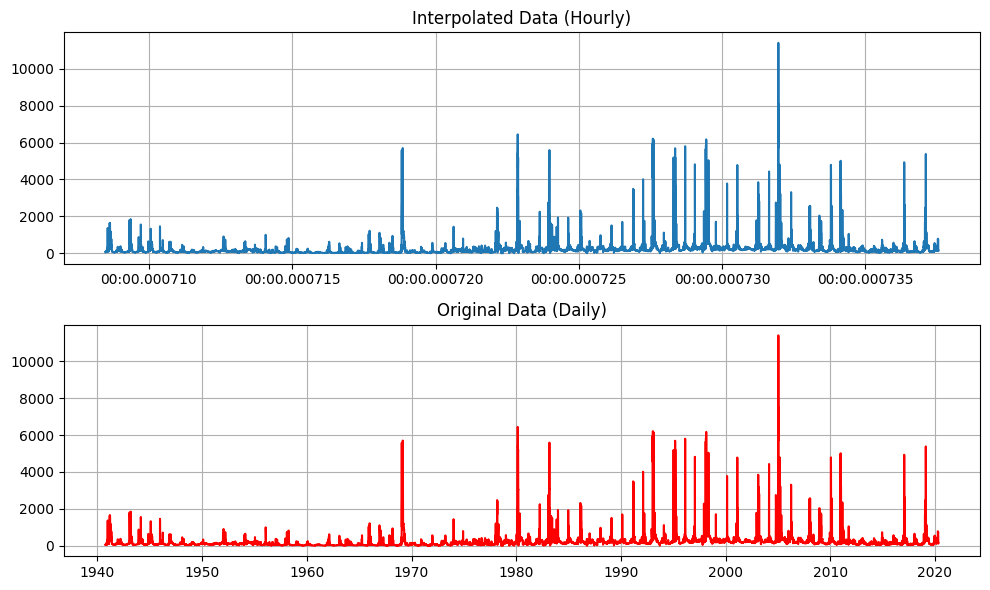

In [29]:
# === Interpolation to hourly ===
# Convert to numeric days since epoch for interpolation
datenum = dates.map(pd.Timestamp.toordinal) + (
    dates.dt.hour / 24 + dates.dt.minute / 1440 + dates.dt.second / 86400
)
firstday = datenum.iloc[0]
lastday = datenum.iloc[-1]
xq = np.arange(firstday, lastday, 1/24)

pchip_interp = PchipInterpolator(datenum, flow)
yq = pchip_interp(xq)

# Plotting
plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
xq_datetime = pd.to_datetime(xq)  # convert back to datetime for plotting
axs[0].plot(xq_datetime, yq)
axs[0].set_title("Interpolated Data (Hourly)")
axs[0].grid()

axs[1].plot(dates, flow, 'r')
axs[1].set_title("Original Data (Daily)")
axs[1].grid()

plt.tight_layout()
plt.show()
